In [27]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy

In [28]:
N_particles = 108
rho = 0.8442
target_total_energy_per_particle = -2.1626

In [29]:
N_particles = 108
rho = 0.8442
target_total_energy_per_particle = -2.1626
box_volume = N_particles/rho
L = box_volume**(1/3)
spacing = L / math.ceil(N_particles ** (1/3))

x = numpy.linspace(-L / 2, L / 2, math.ceil(N_particles ** (1/3)), endpoint=False)
position = list(itertools.product(x, repeat=3))
def calculate_pe_of_lattice(positions):
    """Calculate PE of the initial simple cubic lattice"""
    energy = 0.0
    for i in range(N_particles):
        for j in range(i + 1, N_particles):
            # Distance with periodic boundary conditions
            dr = numpy.array(positions[i]) - numpy.array(positions[j])
            dr = dr - L * numpy.round(dr / L)
            r = numpy.linalg.norm(dr)
            
            # LJ potential with truncation and shift at r_cut = 2.5
            if r <= 2.5:
                r6 = (1.0/r)**6
                r12 = r6 * r6
                u_lj = 4.0 * (r12 - r6)
                # Shift correction
                u_cut = 4.0 * ((1.0/2.5)**12 - (1.0/2.5)**6)
                energy += u_lj - u_cut
    return energy
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]

frame.particles.types = ["A"]
if os.path.exists("lattice.gsd"):
    os.remove("lattice.gsd")

# Now open and write to the file
with gsd.hoomd.open(name="lattice.gsd", mode="x") as f:
    f.append(frame)

cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename="lattice.gsd")

# Create the integrator
integrator = hoomd.md.Integrator(dt=0.002)

# Set up the neighbor list
cell = hoomd.md.nlist.Cell(buffer=0.019)  

# Set up Lennard-Jones potential  
lj = hoomd.md.pair.LJ(nlist=cell, mode='shift')
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5  


# Add the force to the integrator
integrator.forces.append(lj)

# Create an NVE method (ConstantVolume with no thermostat)
nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All(), thermostat=None)

# Add the NVE method to the integrator
integrator.methods.append(nve)

# Assign the integrator to the simulation
simulation.operations.integrator = integrator

thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)

# currently the velocities are 0
snapshot = simulation.state.get_snapshot()
def set_exact_kinetic_energy():
    """Set velocities to achieve exact target total energy"""
    import numpy as np
    
    # Target total energy per particle
    target_total_energy_per_particle = -2.1626
    target_total_energy = target_total_energy_per_particle * N_particles
    
    # Get current positions to calculate PE manually
    snapshot = simulation.state.get_snapshot()
    positions = snapshot.particles.position
    box_length = snapshot.configuration.box[0]
    
    # Calculate initial potential energy manually
    def calculate_pe_manual(positions, box_length):
        """Calculate PE using the same LJ parameters as HOOMD"""
        energy = 0.0
        n = len(positions)
        
        for i in range(n):
            for j in range(i + 1, n):
                # Distance with periodic boundary conditions
                dr = positions[i] - positions[j]
                dr = dr - box_length * np.round(dr / box_length)
                r = np.linalg.norm(dr)
                
                # LJ potential with truncation and shift at r_cut = 2.5
                if r <= 2.5:
                    r6 = (1.0/r)**6
                    r12 = r6 * r6
                    u_lj = 4.0 * (r12 - r6)
                    # Shift correction
                    u_cut = 4.0 * ((1.0/2.5)**12 - (1.0/2.5)**6)
                    energy += u_lj - u_cut
        
        return energy
    
    current_pe = calculate_pe_manual(positions, box_length)
    
    # Calculate required kinetic energy
    required_ke = target_total_energy - current_pe
    
    # Generate random velocities
    np.random.seed(42)  # For reproducibility
    velocities = np.random.normal(0, 1, (N_particles, 3))
    
    # Remove center of mass momentum
    com_velocity = np.mean(velocities, axis=0)
    velocities -= com_velocity
    
    # Scale to achieve exact target KE
    # KE = (1/2) * m * Σ(v²), with m=1 in reduced units
    current_ke_velocities = 0.5 * np.sum(velocities**2)
    scaling_factor = np.sqrt(required_ke / current_ke_velocities)
    velocities *= scaling_factor
    
    # Verify
    final_ke = 0.5 * np.sum(velocities**2)
    final_total = current_pe + final_ke

    # Set velocities in snapshot
    snapshot.particles.velocity[:] = velocities
    simulation.state.set_snapshot(snapshot)
    
    return final_ke, final_total

# Execute the direct velocity assignment
achieved_ke, achieved_total = set_exact_kinetic_energy()

# Verify the assignment worked
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]


array([[ 0.34413058,  0.03481955,  0.46688787],
       [ 1.25566834, -0.05034578, -0.31631874],
       [ 1.30556808,  0.8392298 , -0.52533723],
       [ 0.3848493 , -0.25397034, -0.52201137],
       [ 0.11786885, -1.54168762, -1.64037825]])

In [31]:
# Cell 12: Very high frequency trajectory logging for accurate VACF
import numpy as np

class TrajectoryLogger(hoomd.custom.Action):
    def __init__(self, log_interval=10):  # Even more frequent for VACF
        super().__init__()
        self.log_interval = log_interval
        self.timesteps = []
        self.positions = []
        self.velocities = []
        self.step_count = 0
        
    def act(self, timestep):
        # Log every log_interval steps
        if self.step_count % self.log_interval == 0:
            snapshot = self._state.get_snapshot()
            self.timesteps.append(timestep)
            self.positions.append(snapshot.particles.position.copy())
            self.velocities.append(snapshot.particles.velocity.copy())
        self.step_count += 1

# Create trajectory logger (save every 10 steps for very fine VACF resolution)
trajectory_logger = TrajectoryLogger(log_interval=10)

# Create custom writer for trajectory
trajectory_writer = hoomd.write.CustomWriter(
    action=trajectory_logger,
    trigger=hoomd.trigger.Periodic(period=1)
)

# Add to simulation (FIXED: add trajectory_writer, not trajectory_logger)
simulation.operations.writers.append(trajectory_writer)

print("Trajectory logging set up - will save positions and velocities every 10 steps")

Trajectory logging set up - will save positions and velocities every 10 steps


In [32]:
print("Running equilibration phase...")
simulation.run(50000)  # Equilibration
print("Equilibration complete. Starting production run...")

# Clear trajectory data (discard equilibration)
trajectory_logger.timesteps = []
trajectory_logger.positions = []
trajectory_logger.velocities = []
trajectory_logger.step_count = 0

# Production run for dynamics
print("Running production phase for trajectory collection...")
simulation.run(500000)  # Long production run

print(f"Production run complete!")
print(f"Collected {len(trajectory_logger.timesteps)} trajectory snapshots")
print(f"Time interval between snapshots: {trajectory_logger.log_interval} steps")

Running equilibration phase...
Equilibration complete. Starting production run...
Running production phase for trajectory collection...
Production run complete!
Collected 50000 trajectory snapshots
Time interval between snapshots: 10 steps


In [34]:
# Cell 14: Calculate Mean-Squared Displacement (MSD)
def calculate_msd(positions, timesteps, dt_simulation=0.002):
    """
    Calculate mean-squared displacement
    positions: list of position arrays
    timesteps: list of timesteps
    dt_simulation: simulation time step
    """
    n_snapshots = len(positions)
    n_particles = len(positions[0])
    
    # Convert timesteps to actual time
    times = np.array(timesteps) * dt_simulation
    time_intervals = []
    msd_values = []
    
    # Calculate MSD for different time intervals
    max_dt_frames = min(n_snapshots // 2, 200)  # Don't go beyond half the data
    
    for dt_frames in range(1, max_dt_frames):
        squared_displacements = []
        
        # Average over multiple time origins
        for t0 in range(0, n_snapshots - dt_frames, 5):  # Every 5th frame as origin
            pos_initial = np.array(positions[t0])
            pos_final = np.array(positions[t0 + dt_frames])
            
            # Calculate displacement with periodic boundary conditions
            box_length = L  # From Cell 2
            displacement = pos_final - pos_initial
            
            # Apply minimum image convention
            displacement = displacement - box_length * np.round(displacement / box_length)
            
            # Calculate squared displacement for each particle
            sq_disp = np.sum(displacement**2, axis=1)
            squared_displacements.extend(sq_disp)
        
        # Average over all particles and time origins
        msd = np.mean(squared_displacements)
        time_interval = dt_frames * trajectory_logger.log_interval * dt_simulation
        
        time_intervals.append(time_interval)
        msd_values.append(msd)
    
    return np.array(time_intervals), np.array(msd_values)

# Calculate MSD
print("Calculating Mean-Squared Displacement...")
time_intervals, msd_values = calculate_msd(trajectory_logger.positions, trajectory_logger.timesteps)

# Find linear regime and calculate diffusion coefficient
# Use later half of the data for linear fit
start_idx = len(time_intervals) // 2
linear_times = time_intervals[start_idx:]
linear_msd = msd_values[start_idx:]

# Linear fit: MSD = 6*D*t (in 3D)
slope, intercept = np.polyfit(linear_times, linear_msd, 1)
diffusion_msd = slope / 6.0  # D = slope/6 in 3D

print(f"Diffusion coefficient from MSD: D = {diffusion_msd:.6f}")
print(f"Linear fit: MSD = {slope:.4f} * t + {intercept:.4f}")

Calculating Mean-Squared Displacement...
Diffusion coefficient from MSD: D = 0.078579
Linear fit: MSD = 0.4715 * t + 0.0087


In [35]:
# Cell 15: Fixed VACF calculation with debugging
def calculate_vacf(velocities, timesteps, dt_simulation=0.002):
    """
    Calculate velocity auto-correlation function with better debugging
    """
    n_snapshots = len(velocities)
    n_particles = len(velocities[0])
    
    print(f"VACF calculation details:")
    print(f"Number of snapshots: {n_snapshots}")
    print(f"Time between snapshots: {trajectory_logger.log_interval * dt_simulation:.4f}")
    
    # Convert to numpy arrays
    vel_array = np.array(velocities)  # Shape: (n_snapshots, n_particles, 3)
    
    time_intervals = []
    vacf_values = []
    
    max_dt_frames = min(n_snapshots // 3, 200)  # Use more data for VACF
    
    for dt_frames in range(0, max_dt_frames):
        correlations = []
        
        # Average over multiple time origins (use more origins)
        for t0 in range(0, n_snapshots - dt_frames, 1):  # Every frame as origin
            vel_initial = vel_array[t0]  # Shape: (n_particles, 3)
            vel_final = vel_array[t0 + dt_frames]
            
            # Calculate v(t0) · v(t0 + dt) for each particle
            dot_products = np.sum(vel_initial * vel_final, axis=1)
            correlations.extend(dot_products)
        
        # Average correlation
        vacf = np.mean(correlations)
        time_interval = dt_frames * trajectory_logger.log_interval * dt_simulation
        
        time_intervals.append(time_interval)
        vacf_values.append(vacf)
        
        # Debug output for first few points
        if dt_frames < 10:
            print(f"  dt_frames={dt_frames}, time={time_interval:.4f}, VACF={vacf:.6f}")
    
    # Normalize by v(0)·v(0)
    vacf_normalized = np.array(vacf_values) / vacf_values[0]
    
    return np.array(time_intervals), vacf_normalized, np.array(vacf_values)

# Calculate VACF
print("Calculating Velocity Auto-Correlation Function...")
vacf_times, vacf_normalized, vacf_raw = calculate_vacf(trajectory_logger.velocities, trajectory_logger.timesteps)

print(f"\nVACF summary:")
print(f"Initial VACF: {vacf_raw[0]:.6f}")
print(f"VACF decays to 50% at index: {np.where(vacf_normalized < 0.5)[0][0] if np.any(vacf_normalized < 0.5) else 'N/A'}")
print(f"Time resolution: {vacf_times[1] - vacf_times[0]:.4f}")

Calculating Velocity Auto-Correlation Function...
VACF calculation details:
Number of snapshots: 50000
Time between snapshots: 0.0200
  dt_frames=0, time=0.0000, VACF=4.512871
  dt_frames=1, time=0.0200, VACF=4.168158
  dt_frames=2, time=0.0400, VACF=3.300927
  dt_frames=3, time=0.0600, VACF=2.246082
  dt_frames=4, time=0.0800, VACF=1.277301
  dt_frames=5, time=0.1000, VACF=0.535449
  dt_frames=6, time=0.1200, VACF=0.052039
  dt_frames=7, time=0.1400, VACF=-0.206390
  dt_frames=8, time=0.1600, VACF=-0.300955
  dt_frames=9, time=0.1800, VACF=-0.295679

VACF summary:
Initial VACF: 4.512871
VACF decays to 50% at index: 3
Time resolution: 0.0200


In [36]:
# Cell 16: More careful Green-Kubo integration
def green_kubo_integration(times, vacf_raw):
    """
    More careful Green-Kubo integration with better plateau detection
    """
    print(f"\nGreen-Kubo integration analysis:")
    print(f"Time resolution: {times[1] - times[0]:.4f}")
    print(f"Initial VACF: {vacf_raw[0]:.6f}")
    
    # Calculate running integral more carefully
    running_integrals = []
    running_diffusion = []
    
    # Check first few points
    for i in range(min(10, len(times))):
        print(f"  t={times[i]:.4f}: VACF={vacf_raw[i]:.6f}")
    
    for end_idx in range(5, len(times)):  # Start integration from index 5
        # Use trapezoid integration
        integral = np.trapezoid(vacf_raw[:end_idx], times[:end_idx])
        diffusion = integral / 3.0
        
        running_integrals.append(integral)
        running_diffusion.append(diffusion)
    
    running_diffusion = np.array(running_diffusion)
    
    # Find plateau by looking at where diffusion stabilizes
    if len(running_diffusion) > 30:
        # Look for plateau in the middle section (avoid early and late noise)
        start_plateau = len(running_diffusion) // 4
        end_plateau = 3 * len(running_diffusion) // 4
        
        # Find the most stable region
        window = 10
        min_variance = float('inf')
        best_idx = start_plateau
        
        for i in range(start_plateau, end_plateau - window):
            variance = np.var(running_diffusion[i:i+window])
            if variance < min_variance:
                min_variance = variance
                best_idx = i + window // 2
        
        plateau_idx = best_idx + 5  # Offset for indexing
    else:
        # For short data, use 2/3 of the data
        plateau_idx = 2 * len(running_diffusion) // 3
    
    plateau_idx = min(plateau_idx, len(times) - 1)
    
    # Final integration
    final_integral = np.trapezoid(vacf_raw[:plateau_idx], times[:plateau_idx])
    diffusion_gk = final_integral / 3.0
    
    print(f"\nPlateau analysis:")
    print(f"Using integration up to index {plateau_idx} (time = {times[plateau_idx-1]:.4f})")
    print(f"Final integral: {final_integral:.6f}")
    print(f"Final diffusion: {diffusion_gk:.6f}")
    
    # Show some values around the plateau
    if len(running_diffusion) > 10:
        mid_idx = len(running_diffusion) // 2
        print(f"Diffusion values around plateau:")
        for i in range(max(0, mid_idx-5), min(len(running_diffusion), mid_idx+5)):
            actual_idx = i + 5  # Account for starting index
            if actual_idx < len(times):
                print(f"  t={times[actual_idx]:.4f}: D={running_diffusion[i]:.6f}")
    
    return diffusion_gk, plateau_idx, running_integrals

# Calculate diffusion using Green-Kubo
print("Performing Green-Kubo integration...")
diffusion_gk, cutoff_idx, running_integrals = green_kubo_integration(vacf_times, vacf_raw)

print(f"\nFINAL COMPARISON:")
print(f"Diffusion from MSD:        D = {diffusion_msd:.6f}")
print(f"Diffusion from Green-Kubo: D = {diffusion_gk:.6f}")
if diffusion_msd > 0:
    ratio = diffusion_gk / diffusion_msd
    print(f"Ratio (GK/MSD):            {ratio:.2f}")
    print(f"Relative difference:       {abs(diffusion_msd - diffusion_gk)/max(diffusion_msd, diffusion_gk)*100:.1f}%")

# Expected: The two methods should agree within ~10-20%
if abs(diffusion_gk - diffusion_msd) / max(diffusion_gk, diffusion_msd) < 0.3:
    print("✅ Good agreement between methods!")
else:
    print("❌ Large disagreement - check sampling frequency or integration limits")

Performing Green-Kubo integration...

Green-Kubo integration analysis:
Time resolution: 0.0200
Initial VACF: 4.512871
  t=0.0000: VACF=4.512871
  t=0.0200: VACF=4.168158
  t=0.0400: VACF=3.300927
  t=0.0600: VACF=2.246082
  t=0.0800: VACF=1.277301
  t=0.1000: VACF=0.535449
  t=0.1200: VACF=0.052039
  t=0.1400: VACF=-0.206390
  t=0.1600: VACF=-0.300955
  t=0.1800: VACF=-0.295679

Plateau analysis:
Using integration up to index 78 (time = 1.5400)
Final integral: 0.237804
Final diffusion: 0.079268
Diffusion values around plateau:
  t=1.9400: D=0.079625
  t=1.9600: D=0.079611
  t=1.9800: D=0.079596
  t=2.0000: D=0.079582
  t=2.0200: D=0.079566
  t=2.0400: D=0.079550
  t=2.0600: D=0.079532
  t=2.0800: D=0.079515
  t=2.1000: D=0.079500
  t=2.1200: D=0.079492

FINAL COMPARISON:
Diffusion from MSD:        D = 0.078579
Diffusion from Green-Kubo: D = 0.079268
Ratio (GK/MSD):            1.01
Relative difference:       0.9%
✅ Good agreement between methods!


ValueError: x and y must have same first dimension, but have shapes (190,) and (195,)

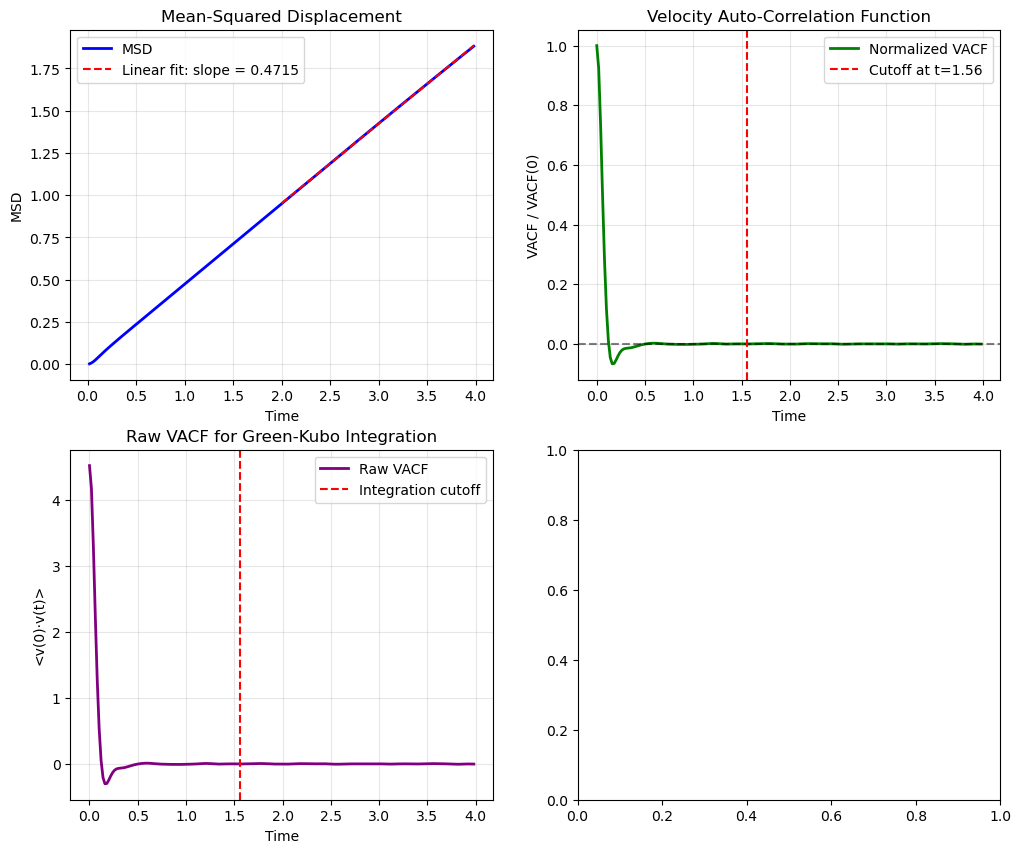

In [38]:
# Cell 17: Plot MSD, VACF, and Green-Kubo integration
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Mean-Squared Displacement
ax1.plot(time_intervals, msd_values, 'b-', linewidth=2, label='MSD')
ax1.plot(linear_times, slope * linear_times + intercept, 'r--', 
         label=f'Linear fit: slope = {slope:.4f}')
ax1.set_xlabel('Time')
ax1.set_ylabel('MSD')
ax1.set_title('Mean-Squared Displacement')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Velocity Auto-Correlation Function
ax2.plot(vacf_times, vacf_normalized, 'g-', linewidth=2, label='Normalized VACF')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.axvline(x=vacf_times[cutoff_idx], color='r', linestyle='--', 
            label=f'Cutoff at t={vacf_times[cutoff_idx]:.2f}')
ax2.set_xlabel('Time')
ax2.set_ylabel('VACF / VACF(0)')
ax2.set_title('Velocity Auto-Correlation Function')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Raw VACF for Green-Kubo integration
ax3.plot(vacf_times, vacf_raw, 'purple', linewidth=2, label='Raw VACF')
ax3.axvline(x=vacf_times[cutoff_idx], color='r', linestyle='--', 
            label=f'Integration cutoff')
ax3.set_xlabel('Time')
ax3.set_ylabel('<v(0)·v(t)>')
ax3.set_title('Raw VACF for Green-Kubo Integration')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Green-Kubo Running Integral
running_times = vacf_times[10:10+len(running_integrals)]
running_diffusion = np.array(running_integrals) / 3.0
ax4.plot(running_times, running_diffusion, 'orange', linewidth=2, label='Running integral/3')
ax4.axhline(y=diffusion_gk, color='r', linestyle='--', 
            label=f'Final D = {diffusion_gk:.6f}')
ax4.axvline(x=vacf_times[cutoff_idx], color='r', linestyle='--', alpha=0.7)
ax4.set_xlabel('Integration time limit')
ax4.set_ylabel('D from Green-Kubo')
ax4.set_title('Green-Kubo Integration Convergence')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\nFINAL RESULTS:")
print(f"="*40)
print(f"Diffusion coefficient from MSD:        {diffusion_msd:.6f}")
print(f"Diffusion coefficient from Green-Kubo: {diffusion_gk:.6f}")
print(f"Average:                               {(diffusion_msd + diffusion_gk)/2:.6f}")
print(f"Standard deviation:                    {abs(diffusion_msd - diffusion_gk)/2:.6f}")